# Grid2Op with Deep SARSA

## Import the necessary software libraries:

In [26]:
import grid2op
import random
import copy
import gym
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from typing import Callable
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

from grid2op.gym_compat import GymEnv, BoxGymObsSpace, DiscreteActSpace
from gym import Env
from gym.utils.env_checker import check_env
try:
    from lightsim2grid import LightSimBackend
    bk_cls = LightSimBackend
except ImportError as exc:
    print(f"Error: {exc} when importing faster LightSimBackend")
    from grid2op.Backend import PandaPowerBackend
    bk_cls = PandaPowerBackend
    
from utils_plot import plot_stats, seed_everything
%matplotlib notebook

## Create and prepare the environment

### Create the environment & Convert into Gym Compatible 

In [27]:
env_name = "rte_case14_redisp"
#env = grid2op.make(env_name, test=True, backend=bk_cls()
env = grid2op.make(env_name)
print(type(env))
gym_env = GymEnv(env)


gym_env.observation_space = BoxGymObsSpace(env.observation_space)
gym_env.action_space = DiscreteActSpace(env.action_space)

#print(f"Is gym_env and open AI gym environment: {isinstance(gym_env, gym.Env)}")

<class 'abc.Environment_rte_case14_redisp'>


e:\masters\sem 2\analytics project\code\grid2op\grid2op\gym_compat\discrete_gym_actspace.py:171: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(


In [28]:
state_dims = gym_env.observation_space.shape[0]
num_actions = gym_env.action_space.n

In [29]:
num_actions

463

### Prepare the environment to work with PyTorch

In [30]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        obs = self.env.reset()
        print(f'type={ type(obs) }')
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [31]:
env = PreprocessEnv(gym_env)

In [32]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)

type=<class 'numpy.ndarray'>


### Create the Q-Network: $\hat q(s,a| \theta)$

In [45]:
q_network = nn.Sequential(
    nn.Linear(state_dims, 550),
    nn.ReLU(),
    nn.Linear(550, 500),
    nn.ReLU(),
    nn.Linear(500, num_actions),
    nn.Softmax(num_actions))

AttributeError: module 'torch.nn' has no attribute 'softmax'

In [34]:
q_network

Sequential(
  (0): Linear(in_features=453, out_features=550, bias=True)
  (1): ReLU()
  (2): Linear(in_features=550, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=463, bias=True)
  (5): Softmax(dim=463)
)

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

In [35]:
target_q_network = copy.deepcopy(q_network).eval()

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [36]:
def policy(state, epsilon=0.05):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

In [37]:
#plot_cost_to_go(gym_env, q_network, xlabel='Car Position', ylabel='Velocity')

In [38]:
class ReplayMemory:

    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        print(f'can_sample_self.memory = {len(self.memory)}')
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

# Deep SARSA Algorithm

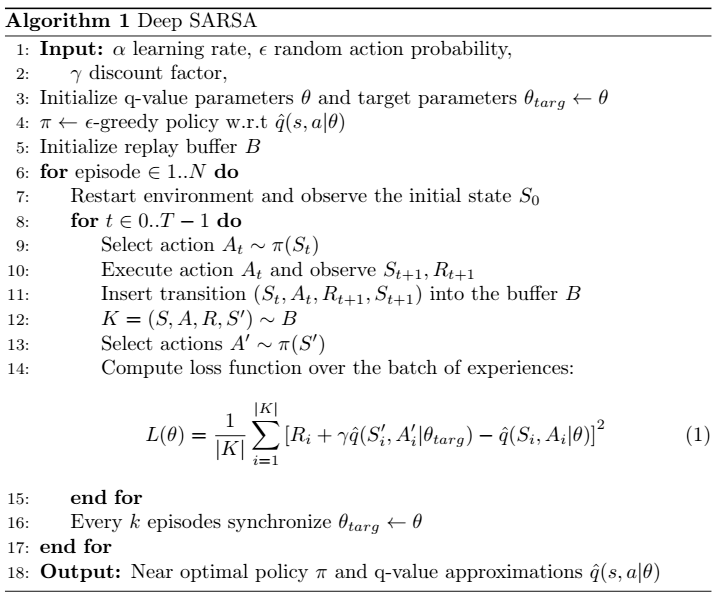

In [39]:
from IPython.display import Image
Image(filename='download.png') 

In [40]:
def deep_sarsa(q_network, policy, episodes, alpha=0.001, batch_size=32, gamma=0.99, epsilon=0.):
    print(f'<<< deep_sarsa >>>')
    optim = AdamW(q_network.parameters(), lr=alpha) #optimiser to optimise weight calculation of neural networks
    memory = ReplayMemory() #Initialising memory to store State, Action, Reward, and Next State
    stats = {'MSE Loss': [], 'Returns': []} #Dict to store statistics
    
    for episode in tqdm(range(1, episodes + 1)):
        print(f'<<< episode >>>')
        state = env.reset() #getting initial state
        done = False
        ep_return = 0
        while not done:
            print(f'<<< while >>>')
            action = policy(state, epsilon) #Getting first action greedily with randomisation factor Epsilon
            next_state, reward, done, _ = env.step(action) #taking selected action on environment
            memory.insert([state, action, reward, done, next_state]) #Storing the results to memory
            print(f'batch_size = {memory.can_sample(batch_size)}') #printing the size of the memory
            if memory.can_sample(batch_size): #samples will be created only if memory pool is 10 times of batch size
                print(f'<<< if memory >>>')
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size) #creating batches to train neural network
                qsa_b = q_network(state_b).gather(1, action_b) #providing the state to neural network and comparing the 
                                                            #actions with actions stored in memory and gather the experiences
                next_action_b = policy(next_state_b) #using greedy epsilon policy to greedily get next actions
                next_qsa_b = target_q_network(next_state_b).gather(1, next_action_b) #provide next state and next action to a target neural network
                                                                                    #and gather its experiences
                target_b = reward_b + ~done_b * gamma * next_qsa_b #discount the experiences of target network
                loss = F.mse_loss(qsa_b, target_b) #find a Mean square error loss
                print(f'qsa_b = {qsa_b}, target_b = {target_b}')
                q_network.zero_grad() #reset the gradients of the network
                loss.backward() #calculate gradients using backward propogation
                optim.step() # Iterate over all parameters (tensors) that are supposed 
                            # to be updated and use internally stored grad to update their values
                
                loss.item() # get the loss
                print(loss.item())
                stats['MSE Loss'].append(loss.item())
            
            state = next_state
            ep_return += reward.item()
        
        stats['Returns'].append(ep_return)
        
        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict()) #After every 10 episodes load state of original network to
                                                                    # target network
        
    return stats

In [41]:
print(q_network)

Sequential(
  (0): Linear(in_features=453, out_features=550, bias=True)
  (1): ReLU()
  (2): Linear(in_features=550, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=463, bias=True)
  (5): Softmax(dim=463)
)


In [42]:
stats = deep_sarsa(q_network, policy, 200, alpha=0.001, epsilon=0.05)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

<<< deep_sarsa >>>
<<< episode >>>
type=<class 'numpy.ndarray'>
<<< while >>>


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 463)

In [20]:
print(stats)

{'MSE Loss': [2375844.75, 5088436.5, 148934096.0, 6128829.0, 66793812.0, 86714056.0, 34752756.0, 122371416.0, 17602574.0, 45964020.0, 40935384.0, 30054684.0, 16265722.0, 4496816.5, 698920.75, 5575220.0, 43543744.0, 36385980.0, 14978548.0, 3181392.25, 7803361.5, 11161882.0, 11837208.0, 10103793.0, 7649597.5, 3984485.0, 2891495.75, 3287455.75, 4108750.5, 1361164.75, 572897.9375, 276383.90625, 342138.84375, 89853.2578125, 178701.875, 5055975.0, 6063861.0, 5776304.5, 3720219.25, 2239389.75, 1595274.125, 1590436.25, 34762232.0, 35345768.0, 30570076.0, 24857896.0, 16299360.0, 9290569.0, 10029487.0, 2752579.0, 3405988.25, 7997517.5, 12808483.0, 13855658.0, 11858585.0, 10494506.0, 5999563.0, 3672106.25, 672283.375, 1696216.0, 3149018.0, 2996269.25, 2642430.5, 2002696.625, 1489426.75, 1692573.375, 1415853.0, 17030168.0, 16680293.0, 14665839.0, 9290231.0, 7906792.0, 8511752.0, 9984770.0, 9117038.0, 8242476.5, 1481299.125, 950045.625, 608150.6875, 1207343.375, 1096141.125, 1478952.875, 1262674.12

# Here Lies the Problem
As you see in above output we are getting nan in the loss which is because we are getting nan in the actions that the neural network is predicting. We are unable to pinpoint the issue it could be because of incorrect gradients, faulty loss function, bad policy or learning rate parameter, or faulty inputs (well inputs are faulty because the previous output is fault, but unable to understand why the first output is coming as nan even when input is correct)

## Show results

### Plot execution stats

<IPython.core.display.Javascript object>


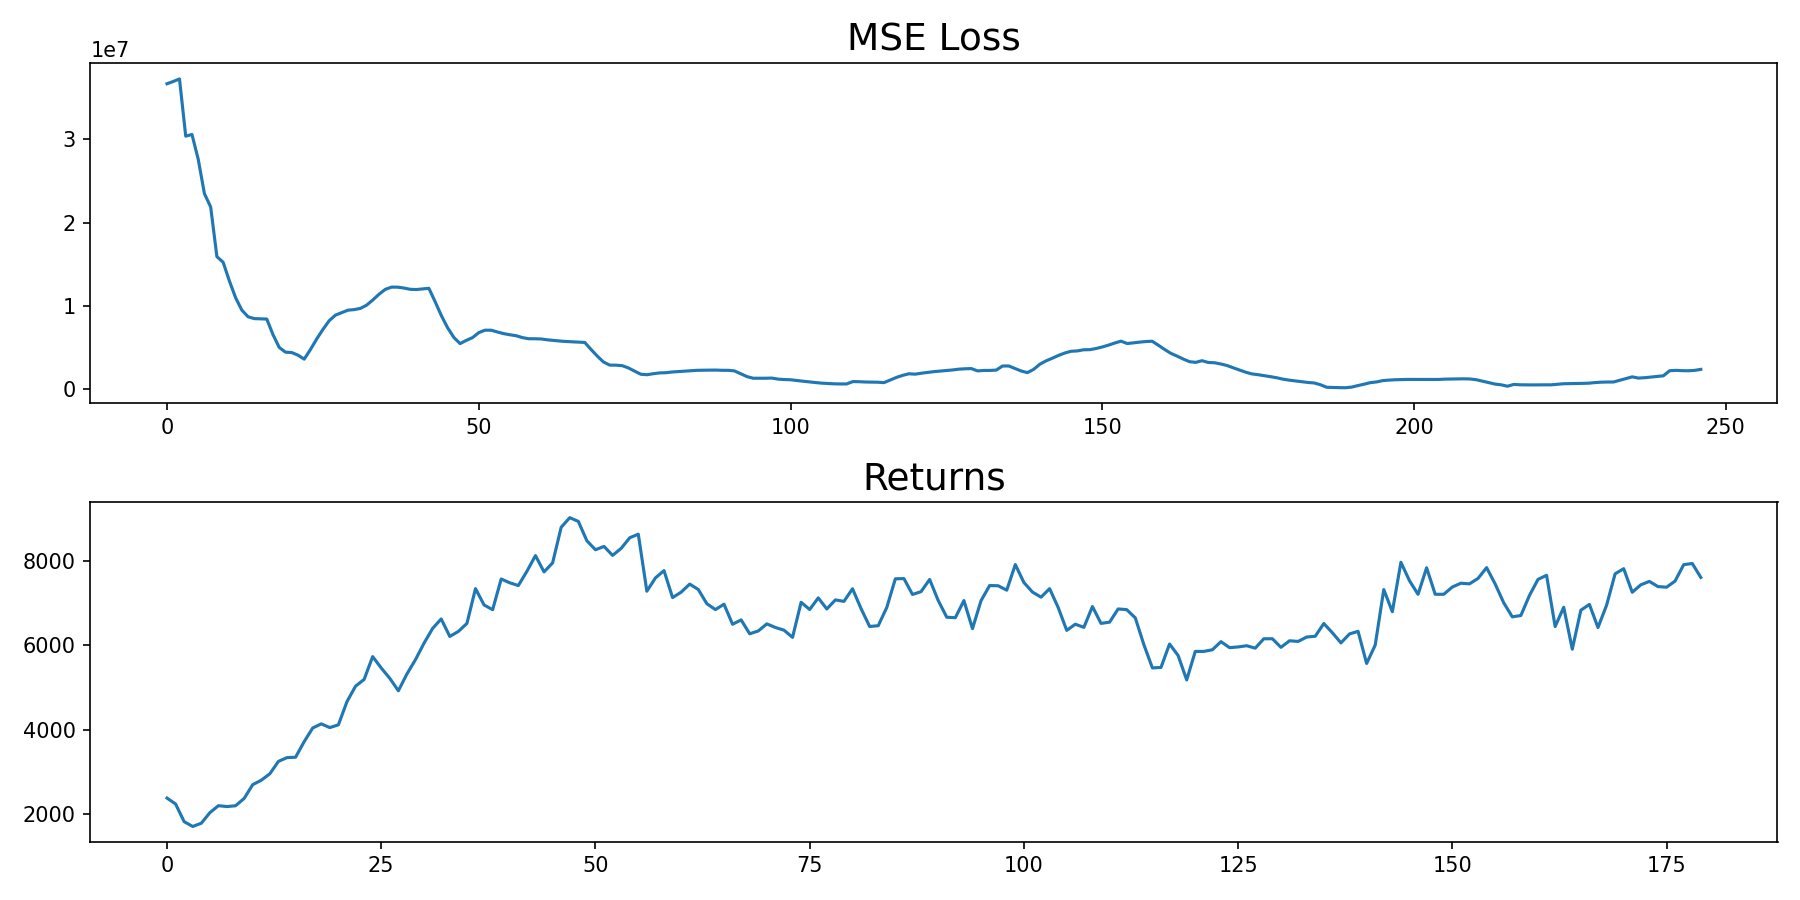

In [21]:
plot_stats(stats)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

In [ ]:
#plot_cost_to_go(gym_env, q_network, xlabel='Car Position', ylabel='Velocity')

### Show resulting policy: $\pi(s)$

In [ ]:
#plot_max_q(gym_env, q_network, xlabel='Car Position', ylabel='Velocity', action_labels=['Back', 'Do nothing', 'Forward'])

### Test the resulting agent

In [ ]:
def test_agent(env: gym.Env, policy: Callable, episodes: int = 10) -> None:
    print('<< test_agent >> ')
    #plt.figure(figsize=(8, 8))
    for episode in range(episodes):
        state = env.reset()
        done = False
        #img = plt.imshow(env.render(mode='rgb_array'))
        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, _, done, _ = env.step(action)
            #img.set_data(env.render(mode='rgb_array'))
            #plt.axis('off')
            #display.display(plt.gcf())
            #display.clear_output(wait=True)
            state = next_state

In [ ]:
#test_agent(gym_env, q_network, episodes=2)

In [3]:
env

{'ACSVCPORT': '17532',
 'ALLUSERSPROFILE': 'C:\\ProgramData',
 'APPDATA': 'C:\\Users\\tejus_\\AppData\\Roaming',
 'CHOCOLATEYINSTALL': 'C:\\ProgramData\\chocolatey',
 'CHOCOLATEYLASTPATHUPDATE': '132940472763106111',
 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files',
 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files',
 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files',
 'COMPUTERNAME': 'JARVIS',
 'COMSPEC': 'C:\\WINDOWS\\system32\\cmd.exe',
 'CONDA_DEFAULT_ENV': 'base',
 'CONDA_EXE': 'C:\\Users\\tejus_\\anaconda3\\Scripts\\conda.exe',
 'CONDA_PREFIX': 'C:\\Users\\tejus_\\anaconda3',
 'CONDA_PROMPT_MODIFIER': '(base) ',
 'CONDA_PYTHON_EXE': 'C:\\Users\\tejus_\\anaconda3\\python.exe',
 'CONDA_SHLVL': '1',
 'DRIVERDATA': 'C:\\Windows\\System32\\Drivers\\DriverData',
 'GAMEFIRSTUSERPATH': 'C:\\ProgramData\\ASUS\\GameFirst',
 'GAMETURBO': 'C:\\Program Files (x86)\\ASUS\\GameFirst\\',
 'GOOGLE_APPLICATION_CREDENTIALS': 'C:\\Users\\tejus_\\AppData\\Roaming\\gclou

1. Try normalised data
2. Figure out softmax
3. Nans are mainly because of activation functions
4. Try changing learning rate